<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/Fetal_Cns_Final_reg_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import random

In [25]:
# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [66]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  # Ensures reproducibility
torch.backends.cudnn.benchmark = False  # Disables the auto-tuner that finds the best algorithm for your hardware

In [67]:

# Determine the available hardware (CPU or GPU) and set the PyTorch device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [68]:
# # Read the list of images from the CSV file
# train_csv = "/content/drive/MyDrive/FinalProject/train_data_95.csv"
# train_csv_df = pd.read_csv(train_csv)
# print("CSV file loaded:")
# print(train_csv_df.head())

In [69]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        pixel_size = self.data_frame.iloc[idx, 1]
        hc = self.data_frame.iloc[idx, 3]  # Normalized head circumference
        sample = {'image': image, 'pixel_size': pixel_size, 'hc': hc}
        return sample

In [70]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=10),   # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize the image to 224x224 with scaling between 80% to 100%
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])



In [82]:
batch_size = 32
num_epochs = 8
step_size = 5
lr = 0.001

In [83]:
root_dir = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"

train_csv = CustomDataset(csv_file='/content/drive/MyDrive/FinalProject/train_data_297.csv',root_dir=root_dir, transform=transform)
val_csv = CustomDataset(csv_file='/content/drive/MyDrive/FinalProject/val_data_297.csv',root_dir=root_dir, transform=transform)
test_csv = CustomDataset(csv_file='/content/drive/MyDrive/FinalProject/test_data_297.csv',root_dir=root_dir, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_csv, batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_csv, batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_csv, batch_size, shuffle=False, num_workers=2)

train_csv_df = pd.read_csv('/content/drive/MyDrive/FinalProject/train_data_95.csv')
val_csv_df = pd.read_csv('/content/drive/MyDrive/FinalProject/val_data_297.csv')
test_csv_df = pd.read_csv('/content/drive/MyDrive/FinalProject/test_data_297.csv')

In [84]:
# # Load the dataset
# root_dir = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"
# dataset = CustomDataset(csv_file=train_csv, root_dir=root_dir, transform=transform)

# # Split the dataset into training and validation sets
# train_size = int(0.95 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size, shuffle=False, pin_memory=True)

In [85]:
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        cnn_out_features = self.cnn.fc.in_features  # Get the number of output features from the CNN
        self.cnn.fc = nn.Identity()  # Remove the last fully connected layer
        self.fc1 = nn.Linear(cnn_out_features + 1, 128)  # Adjust input features
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, image, pixel_size):
        x1 = self.cnn(image)
        x2 = pixel_size.view(-1, 1)  # Ensure x2 has the shape (batch_size, 1)
        x = torch.cat((x1, x2), dim=1)  # Concatenate along the feature dimension
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


In [86]:
# # Initialize the model, loss function, and optimizer
model = CNNRegression().to(device)
for param in model.parameters():
    param.requires_grad = True
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Added L2 regularization
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

optimizer = optim.Adam(model.parameters(), lr)
scheduler = StepLR(optimizer, step_size, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)


Epoch 1/8, Training Loss: 0.10524990104138851
Epoch 1/8, Validation Loss: 0.028065922670066357
Epoch 2/8, Training Loss: 0.008828516388311981
Epoch 2/8, Validation Loss: 0.00734137196559459
Epoch 3/8, Training Loss: 0.006851559244096279
Epoch 3/8, Validation Loss: 0.007944928016513586
Epoch 4/8, Training Loss: 0.004683002163656056
Epoch 4/8, Validation Loss: 0.00826603063615039
Epoch 5/8, Training Loss: 0.007912826780229807
Epoch 5/8, Validation Loss: 0.01391586079262197
Epoch 6/8, Training Loss: 0.004272185349836945
Epoch 6/8, Validation Loss: 0.007039268501102924
Epoch 7/8, Training Loss: 0.0028890198981389404
Epoch 7/8, Validation Loss: 0.004447257379069924
Epoch 8/8, Training Loss: 0.0026379183400422335
Epoch 8/8, Validation Loss: 0.005662175768520683


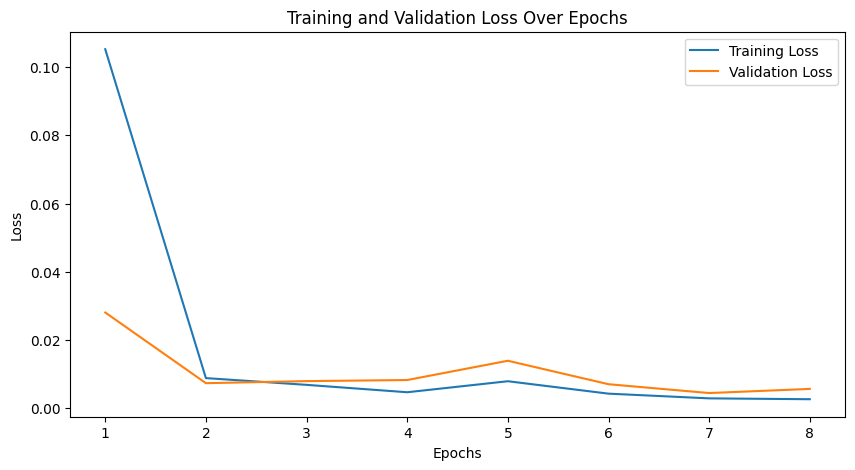

In [88]:
# Lists to store the loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        images = data['image'].to(device)
        pixel_sizes = data['pixel_size'].float().to(device)
        targets = data['hc'].float().to(device)

        optimizer.zero_grad()
        outputs = model(images, pixel_sizes)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data['image'].to(device)
            pixel_sizes = data['pixel_size'].float().to(device)
            targets = data['hc'].float().to(device)

            outputs = model(images, pixel_sizes)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

    scheduler.step()
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Ensure train_losses and val_losses have the same length
if len(train_losses) > len(val_losses):
    train_losses = train_losses[:len(val_losses)]
elif len(val_losses) > len(train_losses):
    val_losses = val_losses[:len(train_losses)]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [89]:
def predict_head_circumference(image_path, pixel_size, model, min_hc, max_hc):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    pixel_size_tensor = torch.tensor([pixel_size]).float().view(1, 1)  # Ensure it has the shape (1, 1)

    with torch.no_grad():
        output = model(image_tensor.to(device), pixel_size_tensor.to(device))

    predicted_normalized_hc = output.item()
    predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc  # De-normalize the prediction
    return predicted_hc


In [90]:
# # Read the list of images from the CSV file
# test_csv = "/content/drive/MyDrive/FinalProject/test_data_5.csv"
# test_csv_df = pd.read_csv(test_csv)
# print("CSV file loaded:")
# print(test_csv_df.head())


In [94]:
# Ensure the min_hc and max_hc are defined
dataset = pd.read_csv('/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv')
min_hc = dataset['head circumference (mm)'].min()
max_hc = dataset['head circumference (mm)'].max()
# min_hc = min(train_csv_df['head circumference (mm)'].min(), test_csv_df['head circumference (mm)'].min())
# max_hc = max(train_csv_df['head circumference (mm)'].max(), test_csv_df['head circumference (mm)'].max())
num_images_to_test = len(test_csv_df)
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1

train data =  <__main__.CustomDataset object at 0x79ba40226e60>
test data =  <__main__.CustomDataset object at 0x79ba68fe3dc0>
batch size =  32
num_epochs =  8
step_size =  5
Results saved to /content/drive/MyDrive/FinalProject/results_28.7.csv
Total Images with Error < 5% of Ground Truth: 41
Percentage: 41.00%
Total Images with Error < 10% of Ground Truth: 77
Percentage: 77.00%
Image with the biggest absolute error:
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/739_HC.png
Predicted Head Circumference: 228.20371280312537
Ground Truth Head Circumference: 275.9
Absolute Error: 47.69628719687461
Mean Squared Error: 234.6820103122453
Root Mean Squared Error: 15.31933452576336
Mean Absolute Error: 11.610577577959003
R² Score: 0.9357219424634737


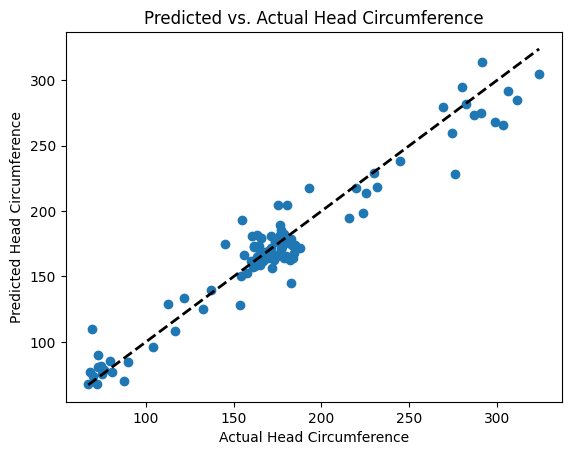

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("train data = ", train_csv)
print("test data = ", test_csv)
print("batch size = ", batch_size)
print("num_epochs = ", num_epochs)
print("step_size = ", step_size)

# Initialize lists to store true and predicted values
y_true = []
y_pred = []
results = []
absolute_errors = []
percentage_errors = []
counter = 0
percentage_error_counter_5 = 0  # Counter for errors less than 5%
percentage_error_counter_10 = 0  # Counter for errors less than 10%
threshold_param = 0.05  # Threshold for the ground truth circumference

# Variables to track the maximum absolute error and corresponding details
max_absolute_error = -1
max_error_image = ""
max_error_predicted = -1
max_error_ground_truth = -1

# Loop through the selected images
for idx in indices:
    image_name = test_csv_df.iloc[idx, 0]
    image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", image_name)
    ground_truth_circumference = test_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels
    pixel_size = test_csv_df.iloc[idx, 1]  # Assuming the second column contains the pixel size

    # Call the function to predict head circumference from the image
    predicted_circumference = predict_head_circumference(image_path, pixel_size, model, min_hc, max_hc)

    # Store the true and predicted values
    y_true.append(ground_truth_circumference)
    y_pred.append(predicted_circumference)

    # Calculate the absolute error
    absolute_error = abs(predicted_circumference - ground_truth_circumference)
    absolute_errors.append(absolute_error)

    # Calculate the percentage error
    percentage_error = (absolute_error / ground_truth_circumference) * 100
    percentage_errors.append(percentage_error)

    # Calculate the 5% and 10% thresholds for the ground truth circumference
    threshold_5 = 0.05 * ground_truth_circumference
    threshold_10 = 0.10 * ground_truth_circumference

    # Check if the absolute error is less than the 5% and 10% thresholds
    if absolute_error < threshold_5:
        percentage_error_counter_5 += 1
    if absolute_error < threshold_10:
        percentage_error_counter_10 += 1

    # Track the maximum absolute error
    if absolute_error > max_absolute_error:
        max_absolute_error = absolute_error
        max_error_image = image_path
        max_error_predicted = predicted_circumference
        max_error_ground_truth = ground_truth_circumference

    # Create the result string
    result_string = (f"Image: {image_path}\n"
                     f"Predicted Head Circumference: {predicted_circumference}\n"
                     f"Ground Truth Head Circumference: {ground_truth_circumference}\n"
                     f"Pixel Size: {pixel_size}\n"
                     f"Absolute Error: {absolute_error}\n"
                     f"Percentage Error: {percentage_error}%\n"
                     "****************************\n")

    # Append the result to the list
    results.append([image_name, result_string, absolute_error])

# Convert the results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results, columns=['Image', 'Result', 'Absolute Error'])
results_csv_path = "/content/drive/MyDrive/FinalProject/results_28.7.csv"
results_df.to_csv(results_csv_path, index=False)

# Print summary
print(f"Results saved to {results_csv_path}")
print(f"Total Images with Error < 5% of Ground Truth: {percentage_error_counter_5}")
print(f"Percentage: {percentage_error_counter_5 / num_images_to_test * 100:.2f}%")
print(f"Total Images with Error < 10% of Ground Truth: {percentage_error_counter_10}")
print(f"Percentage: {percentage_error_counter_10 / num_images_to_test * 100:.2f}%")

# Print the image with the biggest absolute error
print("Image with the biggest absolute error:")
print(f"Image: {max_error_image}")
print(f"Predicted Head Circumference: {max_error_predicted}")
print(f"Ground Truth Head Circumference: {max_error_ground_truth}")
print(f"Absolute Error: {max_absolute_error}")

# Calculate RMSE, MAE, and R²
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.scatter(y_true, y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.xlabel('Actual Head Circumference')
plt.ylabel('Predicted Head Circumference')
plt.title('Predicted vs. Actual Head Circumference')
plt.show()
